In [2]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 路径声明

In [4]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 设定分类数

In [6]:
NUM_CLASSES = 8

# 读取学习数据

In [8]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [10]:
# 读入从1到21*2的数据（表的每行共有21个数据（对应21个特征点） 每个数据有两个值（xy坐标轴值））作为x

In [12]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [14]:
# 第0列的值代表属于哪种手势

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# 模型构建

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [20]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                860       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 88        
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 模型检查点回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 用于提前结束的回调
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [24]:
# 模型编译
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 模型训练

In [26]:
model.fit(
    X_train,
    y_train,
    epochs=10000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/10000
58/58 [==============================] - 0s 8ms/step - loss: 0.8940 - accuracy: 0.6548 - val_loss: 0.5598 - val_accuracy: 0.8630

Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 2/10000
58/58 [==============================] - 0s 5ms/step - loss: 0.8991 - accuracy: 0.6509 - val_loss: 0.5550 - val_accuracy: 0.8622

Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 3/10000
58/58 [==============================] - 0s 5ms/step - loss: 0.8815 - accuracy: 0.6616 - val_loss: 0.5479 - val_accuracy: 0.8679

Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 4/10000
58/58 [==============================] - 0s 5ms/step - loss: 0.8739 - accuracy: 0.6597 - val_loss: 0.5535 - val_accuracy: 0.8716

Epoch 00004: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 5/10000
58/58 [==============================] - 0s 5ms/step - loss: 0.9070 - accuracy: 0.6499 - v

In [28]:
# 模型评估
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

20/20 [==============================] - 0s 2ms/step - loss: 0.5799 - accuracy: 0.8324


In [30]:
# 加载保存的模型
model = tf.keras.models.load_model(model_save_path)

In [32]:
# 推理测试
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[4.0856940e-03 2.7822351e-01 1.1985532e-02 7.0959423e-04 4.5586079e-02
 5.0019210e-08 1.4517969e-05 6.5939510e-01]
7


# 混淆矩阵

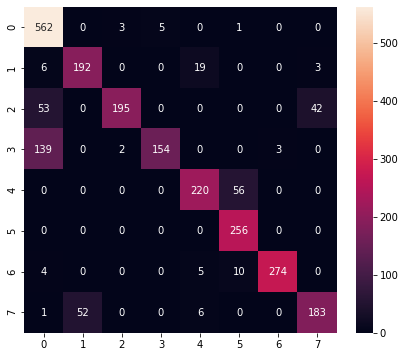

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       571
           1       0.79      0.87      0.83       220
           2       0.97      0.67      0.80       290
           3       0.97      0.52      0.67       298
           4       0.88      0.80      0.84       276
           5       0.79      1.00      0.88       256
           6       0.99      0.94      0.96       293
           7       0.80      0.76      0.78       242

    accuracy                           0.83      2446
   macro avg       0.87      0.82      0.82      2446
weighted avg       0.86      0.83      0.83      2446



In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# 转化为Tensorflow-Lite用模型

In [36]:
# 保存为仅供推理的模型
model.save(model_save_path, include_optimizer=False)

In [38]:
# 转换模型（量化）
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Van5SE\AppData\Local\Temp\tmpd_o7ikui\assets
INFO:tensorflow:Assets written to: C:\Users\Van5SE\AppData\Local\Temp\tmpd_o7ikui\assets


6576

# 推理测试

In [40]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [42]:
# 获取 I/O 张量
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [44]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [46]:
%%time
# 推理实施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 998 µs


In [48]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.0856949e-03 2.7822363e-01 1.1985533e-02 7.0959469e-04 4.5586091e-02
 5.0019292e-08 1.4517994e-05 6.5939492e-01]
7
